# PySAMOSA

This jupyter notebook demonstrates exemplarily how to retrack a Level-1B (L1b) data file from the Sentinel-3 and Sentinel-6 MF missions.

## Getting-started

Install pysamosa package from PyPI

>    $ pip install pysamosa

### Imports

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import logging
from pathlib import Path

import numpy as np
import matplotlib as mpl

import pysamosa
from pysamosa.common_types import L1bSourceType
from pysamosa.data_access import data_vars_s3, data_vars_s6
from pysamosa.retracker_processor import RetrackerProcessor
from pysamosa.settings_manager import get_default_base_settings, SettingsPreset
from pysamosa.utils import plot_l2_results_vs_ref

%aimport pysamosa

### Choosing the L1b files to be retracked

Download auxiliary data

In [3]:
from pysamosa.download_aux_data import download_test_data

test_data_path = download_test_data()

Select the files to be processed, here we choose only one:

In [4]:
l1b_files = []

dest_path = Path.cwd().parent / '.testrun' / 'jupyter_getting_started'
src_data_path = test_data_path

# S3
l1b_src_path = src_data_path / 's3' / 'l1b'
l1b_file_path = l1b_src_path / 'S3A_SR_1_SRA____20180414T050108_20180414T055136_20190706T231129_3028_030_090______MR1_R_NT_004.nc'
l2_ref_file = l1b_file_path.parent.parent / 'l2' / 'S3A_SR_1_SRA____20180414T050108_20180414T055136_20190706T231129_3028_030_090______MR1_R_NT_004.nc'
bbox = np.array([-13.32, -13.14, 0, 360])  #[lat_min, lat_max, lon_min, lon_max], set to None if full L1b file shall be retracked

# S6
# l1b_src_path = src_data_path / 's6' / 'l1b'
# l1b_file_path = l1b_src_path / 'S6A_P4_1B_HR______20211120T051224_20211120T060836_20220430T212619_3372_038_018_009_EUM__REP_NT_F06.nc'
# l2_ref_file = l1b_file_path.parent.parent / 'l2' / 'S6A_P4_2__HR_STD__NT_038_018_20211120T051224_20211120T060836_F06.nc'
# bbox = np.array([-29.05, -29.00, 0, 360])  #[lat_min, lat_max, lon_min, lon_max], set to None if full L1b file shall be retracked

l1b_files.append(l1b_file_path)

is_s6 = 's6' in l1b_file_path.name.lower()

### Choosing the Retracker

Set the retracking settings used for the processing.

One can choose between a different`SettingsPreset` to select different retracker presets. The respective individual settings are then returned from the `get_default_base_settings` function. The `L1bSourceType` needs to be selected according to the type of L1b data, e.g. `L1bSourceType.EUM_S6_F06` for Sentinel-6 MF baseline F06.

Here are some sample retracker configuration:
- Standard SAMOSA-based (SAMOSA2) retracker as used in [2]: SettingsPreset.NONE
- SAMOSA+ [3]: SettingsPreset.SAMPLUS
- CORALv2 (UF-SAR) [5]: SettingsPreset.CORALv2

In [5]:
l1b_src_type = L1bSourceType.EUM_S6_F06 if is_s6 else L1bSourceType.EUM_S3
data_vars = data_vars_s6 if is_s6 else data_vars_s3

pres = SettingsPreset.CORALv2
# pres = SettingsPreset.NONE
rp_sets, retrack_sets, fitting_sets, wf_sets, sensor_sets = get_default_base_settings(settings_preset=pres, l1b_src_type=l1b_src_type)

rp_sets.nc_dest_dir = dest_path
rp_sets.n_offset = 0
rp_sets.n_inds = 0  #0 means all
rp_sets.n_procs = 6  #use 6 cores in parallel
rp_sets.skip_if_exists = False

Set additional attributes that are written to top-level of target netCDF file to be written out

In [6]:
additional_nc_attrs = {
    'L1B source type': l1b_src_type.value.upper(),
    'Retracker preset': pres.value.upper(),
}

Set up `RetrackerProcessor` object

In [7]:
data_vars['l1b']

{'wf': 'i2q2_meas_ku_l1b_echo_sar_ku',
 'time': 'time_l1b_echo_sar_ku',
 'lat_rad': 'lat_l1b_echo_sar_ku',
 'lon_rad': 'lon_l1b_echo_sar_ku',
 'alt_m': 'alt_l1b_echo_sar_ku',
 'h_rate_m_per_s': 'orb_alt_rate_l1b_echo_sar_ku',
 'Vs_m_per_s': 'x_vel_l1b_echo_sar_ku',
 'beam_ang_stack_rad': 'beam_ang_stack_l1b_echo_sar_ku',
 'epoch_ref_gate': 'epoch_ref_gate_const',
 'tracker_range_m': 'range_ku_l1b_echo_sar_ku'}

In [8]:
rp = RetrackerProcessor(l1b_source=l1b_files, l1b_data_vars=data_vars['l1b'],
                        rp_sets=rp_sets,
                        retrack_sets=retrack_sets,
                        fitting_sets=fitting_sets,
                        wf_sets=wf_sets,
                        sensor_sets=sensor_sets,
                        nc_attrs_kw=additional_nc_attrs,
                        bbox=[bbox],
                        log_level=logging.DEBUG,  #comment in to show debug messages
                        )

2023-06-16 06:01:15,202 [MainThread  ] [INFO ]  Started retracking processing of 1 L1B files!(n_cores=6)
L1B source type: EUM_S3, Retracker preset: CORALV2 (to_start: 00:00:01, to_last: 00:00:00)


Start processing

In [9]:
rp.process()

2023-06-16 06:01:15,208 [MainThread  ] [INFO ]  Reading of L1B dataset S3A_SR_1_SRA____20180414T050108_20180414T055136_20190706T231129_3028_030_090______MR1_R_NT_004...  (to_start: 00:00:01, to_last: 00:00:00)
2023-06-16 06:01:15,748 [MainThread  ] [INFO ]  File /home/schlembach/miniconda3/envs/test/lib/python3.8/site-packages/pysamosa/.data/dist2coast_1deg_merged.tar already exists, skipping download... (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:15,755 [MainThread  ] [DEBUG]  Creating converter from 7 to 5 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:15,756 [MainThread  ] [DEBUG]  Creating converter from 5 to 7 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:15,756 [MainThread  ] [DEBUG]  Creating converter from 7 to 5 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:15,756 [MainThread  ] [DEBUG]  Creating converter from 5 to 7 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:15,786 [MainThread  ] [INFO ]  Finished reading. (to_start:

2023-06-16 06:01:16,173 [MainThread  ] [DEBUG]  WARNING: the following params were not set, now taking defaults: ksix_rad,ksiy_rad,rip,pri_hz,stack_mask_start_stop (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,173 [MainThread  ] [DEBUG]  WARNING: the following params were not set, now taking defaults: ksix_rad,ksiy_rad,rip,pri_hz,stack_mask_start_stop (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,174 [MainThread  ] [DEBUG]  WARNING: the following params were not set, now taking defaults: ksix_rad,ksiy_rad,rip,pri_hz,stack_mask_start_stop (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,173 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=21.87ns, Pu=1.00W (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,174 [MainThread  ] [DEBUG]  WARNING: the following params were not set, now taking defaults: ksix_rad,ksiy_rad,rip,pri_hz,stack_mask_start_stop (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,175 [MainThr

2023-06-16 06:01:16,213 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=21.874999999999996 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,213 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=25.249999999999996 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,214 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=25.249999999999996 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,216 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,224 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=24.999999999999996 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,225 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=24.999999999999996 (to_start: 00:00

2023-06-16 06:01:16,344 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9390807186108764, Hs=2.1253017657576483, t0_ns=16.933070763975344 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,345 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9645504589686108, Hs=1.862595408942861, t0_ns=18.789468813440102 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,349 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.011388295460756, Hs=2.2156198601593537, t0_ns=24.315667769521617 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,353 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9484715257969851, Hs=2.1042591740174736, t0_ns=16.933070763975344 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,353 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9317607429575439, Hs=2.6449697511347434, t0_ns=21.709852700545078 (to_start: 00:00:02, to_last: 00:00:00)
20

2023-06-16 06:01:16,441 [MainThread  ] [DEBUG]  Starting second iteration step with updated interference_masking_swh_max=2.5991299201859097.  (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,441 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=21.87ns, Pu=1.00W (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,442 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=25.00ns, Pu=1.00W (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,442 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,442 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=24.999999999999996 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,443 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=2.0, t0_ns=24.999999999999996 (to_start: 00:00:02, to_last: 00:00:00)
202

2023-06-16 06:01:16,539 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9508513491870857, Hs=2.0350730916627304, t0_ns=18.74809595906814 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,541 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.00739864352538, Hs=2.141941249209838, t0_ns=24.33800217182933 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,542 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9225353890668752, Hs=2.6449697511347434, t0_ns=21.92695122755053 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,546 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8282894595912842, Hs=3.563088918744282, t0_ns=18.24351233347251 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16 06:01:16,548 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9603598626789566, Hs=2.014923853131416, t0_ns=18.74809595906814 (to_start: 00:00:02, to_last: 00:00:00)
2023-06-16

2023-06-16 06:01:16,638 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9384020399196863, Hs=2.625121219387769, t0_ns=21.762354908192886 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,641 [MainThread  ] [DEBUG]  Starting second iteration step, taking SWH=1.8651152866451344 from first step.  (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,642 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=0.00m,epoch=21.87ns, Pu=1.00W (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,642 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=21.874999999999996 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,647 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9549237567649066, Hs=1.982650805258656, t0_ns=16.930302519946625 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,649 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0077699429802311

2023-06-16 06:01:16,735 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.007721723798501, Hs=2.1355048747312892, t0_ns=24.312862812646635 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,736 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9686935932356939, Hs=7.511312878952255e-11, t0_ns=18.811104708067788 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,738 [MainThread  ] [DEBUG]  Starting second iteration step, taking SWH=1.9402138710356274 from first step.  (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,740 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=0.00m,epoch=21.87ns, Pu=1.00W (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,740 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=21.874999999999996 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,745 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.978380529168

2023-06-16 06:01:16,833 [MainThread  ] [DEBUG]  Processing waveform #25499 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,834 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=18.75ns, Pu=1.00W (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,834 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0177554374656805, Hs=2.1349121954135106, t0_ns=24.06433156868633 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,834 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=18.749999999999996 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,838 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9414895992964954, Hs=468.7482513181784, t0_ns=21.993109685400857 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,842 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9733712699246682, Hs=65.54771717898738, t0_ns=17.01368777856328 (to_sta

2023-06-16 06:01:16,925 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8145886851765544, Hs=3.323967339168542, t0_ns=17.868142581013586 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,925 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9661801556574758, Hs=36.21109222073265, t0_ns=16.941081502607123 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,930 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8878081565083067, Hs=2.668780228781504, t0_ns=12.956041939258013 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,932 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0076202428639363, Hs=2.134182949062357, t0_ns=24.29497932776372 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:16,935 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8227345720283199, Hs=3.2910567714540018, t0_ns=17.868142581013586 (to_start: 00:00:03, to_last: 00:00:00)
2023-

2023-06-16 06:01:17,022 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.948646490343474, Hs=2.28001974766468, t0_ns=24.04117489785998 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,025 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.921449030482041, Hs=2.131578237693037, t0_ns=15.752878925550261 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,025 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9586070825926112, Hs=2.4221233452224267, t0_ns=13.3381858854054 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,033 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0176613199383335, Hs=2.133784446812688, t0_ns=24.048868029729313 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,036 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9586070825926112, Hs=2.4221233452224267, t0_ns=13.471567744259454 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-1

2023-06-16 06:01:17,131 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=22.093749999999996 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,133 [MainThread  ] [DEBUG]  Starting second iteration step, taking SWH=2.1334437300885876 from first step.  (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,134 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=0.00m,epoch=25.00ns, Pu=1.00W (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,135 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9409100245804198, Hs=2.4209941430403594, t0_ns=23.85466149482876 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,135 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=24.999999999999996 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,141 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=21.874999999999996 (to_star

2023-06-16 06:01:17,254 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8870497967933362, Hs=2.6856763747351198, t0_ns=12.94334920203926 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,255 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.008489672792122, Hs=3.9383591234264434e-11, t0_ns=24.094570524707173 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,256 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9581329552469088, Hs=2.28001974766468, t0_ns=24.04117489785998 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,256 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9102379777798949, Hs=2.497676157902557, t0_ns=15.449967698377968 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,265 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.008489672792122, Hs=3.9383591234264434e-11, t0_ns=24.335516229954244 (to_start: 00:00:03, to_last: 00:00:00)

2023-06-16 06:01:17,358 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9314859109961259, Hs=2.4218265782581017, t0_ns=23.854048809017016 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,363 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9586090363215816, Hs=2.4221687410938446, t0_ns=13.338160382874102 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,366 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9207541456052052, Hs=2.161255748712002, t0_ns=15.754310812827732 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,366 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0082248095228143, Hs=3.977742714660708e-11, t0_ns=24.083750248642875 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,367 [MainThread  ] [DEBUG]  Starting second iteration step, taking SWH=2.4209941430403594 from first step.  (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,368 [MainT

2023-06-16 06:01:17,462 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0179745182131181, Hs=7.70252425020268e-16, t0_ns=24.07444486862715 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,465 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9365108685425678, Hs=218.05650983311207, t0_ns=17.89576540306684 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,467 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=18.937499999999996 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,468 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9330193609479672, Hs=81.52778093005223, t0_ns=23.860462164236118 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,472 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.1639343968819975, Hs=7.70252425020268e-16, t0_ns=-1.7368681152448957 (to_start: 00:00:03, to_last: 00:00:00)
2023-06-16 06:01:17,474 [M

2023-06-16 06:01:17,568 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9285569606590897, Hs=1106.2887034273426, t0_ns=15.778456354524836 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,571 [MainThread  ] [DEBUG]  Finished fitting (n_iter=((6, 6), 5)). Found params: swh=2.42m, epoch=23.85ns, Pu=0.93W, nu=5.20e+01.  (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,571 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.007567477979481, Hs=7.70252425020268e-16, t0_ns=23.975515478492262 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,571 [MainThread  ] [DEBUG]  Finished waveform #25479 (n_iter=((6, 6), 5)). SWH=2.42m,epoch=23.85ns, Pu=0.93W.  (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,572 [MainThread  ] [DEBUG]  Processing waveform #25480 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,573 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=21.87ns, Pu=1.00W (to_start:

2023-06-16 06:01:17,655 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9136877707474748, Hs=2.466848237407169, t0_ns=17.625372052094885 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,657 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9641597764054405, Hs=867.0945055154436, t0_ns=13.358950652145174 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,661 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9210496684425928, Hs=32.15572749464215, t0_ns=15.754969193837095 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,666 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9641597764054405, Hs=867.0945055154436, t0_ns=13.492540158666625 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,670 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9210496684425928, Hs=32.15572749464215, t0_ns=15.912518885775466 (to_start: 00:00:04, to_last: 00:00:00)
2023-

2023-06-16 06:01:17,756 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8664646782107182, Hs=2.3267674265419083, t0_ns=21.70983784804319 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,758 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9996954541234114, Hs=1.982199416009958, t0_ns=17.782520523625916 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,759 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9353257552291471, Hs=1.6409380873155177, t0_ns=18.411241690824628 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,764 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9978042180684691, Hs=2.7342562127217924, t0_ns=23.16886408510634 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,765 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8751293249928254, Hs=2.303730125289018, t0_ns=21.70983784804319 (to_start: 00:00:04, to_last: 00:00:00)
2023-

2023-06-16 06:01:17,851 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=22.093749999999996 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,857 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9413667895732735, Hs=1.5828017498663207, t0_ns=18.435751440243276 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,857 [MainThread  ] [DEBUG]  Starting second iteration step with updated interference_masking_swh_max=2.400513896045781.  (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,858 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=25.00ns, Pu=1.00W (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,859 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=24.999999999999996 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,861 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=21.874999999999

2023-06-16 06:01:17,948 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9226840713530811, Hs=2.4455370480816234, t0_ns=17.452544907930914 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,951 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0006693204704111, Hs=2.5078799061149826, t0_ns=22.891795644336263 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,953 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8667578074975344, Hs=2.29917571527867, t0_ns=21.714121303340544 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,954 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9240879213377825, Hs=1.8441282518933804, t0_ns=18.34643330670425 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:17,958 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9821104840335437, Hs=2.0992938191417316, t0_ns=17.621660019183217 (to_start: 00:00:04, to_last: 00:00:00)
202

2023-06-16 06:01:18,042 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.002064864619525, Hs=1.9463902565535471, t0_ns=17.784658602784106 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,043 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=1e-10, t0_ns=24.999999999999996 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,048 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8613763357534813, Hs=2.053887905314043, t0_ns=20.358158239680506 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,048 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9405642761149081, Hs=1.5894552000419595, t0_ns=18.42883089329234 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,051 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.002064864619525, Hs=1.9658541591190826, t0_ns=17.60857287404367 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,053 [MainThr

2023-06-16 06:01:18,143 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9233846805094992, Hs=81.1706021787288, t0_ns=19.200155200394782 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,143 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8916300317007303, Hs=9.590305875559972, t0_ns=21.720138361310894 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,150 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0015765738154103, Hs=3.1840516971644066e-11, t0_ns=22.904065082354503 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,151 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9978860269144305, Hs=301.57783672545116, t0_ns=18.68043845688877 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,152 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9233846805094992, Hs=81.1706021787288, t0_ns=19.39215675239873 (to_start: 00:00:04, to_last: 00:00:00)
202

2023-06-16 06:01:18,240 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9418864722256625, Hs=6.119925297779644, t0_ns=18.437086904793627 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,240 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.862446943072586, Hs=182.05547216049757, t0_ns=20.376890912678586 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,241 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.003190595101567, Hs=107.28089600932765, t0_ns=17.787477624266664 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,248 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8410689964703283, Hs=3.1394019302060414, t0_ns=18.147813213896065 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,250 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9513053369479191, Hs=6.059331977999648, t0_ns=18.437086904793627 (to_start: 00:00:04, to_last: 00:00:00)
2023

2023-06-16 06:01:18,328 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9433163210073445, Hs=1.7226325889409921, t0_ns=17.079031424187026 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,330 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=18.749999999999996 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,337 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=18.749999999999996 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,338 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=21.874999999999996 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,338 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.952749484217418, Hs=1.7055768207336557, t0_ns=17.079031424187026 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,340 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: 

2023-06-16 06:01:18,447 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9129219520940826, Hs=2.039125075473037, t0_ns=13.581651233614554 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,448 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8843038233537662, Hs=4.034975702401656, t0_ns=14.412785279486718 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,448 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8281672180758464, Hs=2.962408295875865, t0_ns=11.26581619086836 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,450 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9916041678705131, Hs=1.3450608281266836, t0_ns=17.121136928730277 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,457 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9220511716150234, Hs=2.0189357182901357, t0_ns=13.581651233614554 (to_start: 00:00:04, to_last: 00:00:00)
2023

2023-06-16 06:01:18,538 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9248357775120816, Hs=1.9034693992207696, t0_ns=13.622228640817065 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,543 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9919821655942742, Hs=2.9674890216038903, t0_ns=14.828165778210593 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,548 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8420375766215646, Hs=3.0966535915124314, t0_ns=18.333323510363574 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,548 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9248357775120816, Hs=1.9034693992207696, t0_ns=13.758450927225235 (to_start: 00:00:04, to_last: 00:00:00)
2023-06-16 06:01:18,548 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9808756738396229, Hs=2.0229423043764614, t0_ns=11.884905009858626 (to_start: 00:00:04, to_last: 00:00:00)


2023-06-16 06:01:18,640 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9433820313276609, Hs=1.7104002652780201, t0_ns=17.079457173992736 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,640 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9909681819071503, Hs=2.980745835137913, t0_ns=14.974331799090177 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,644 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=18.749999999999996 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,646 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8642038389732997, Hs=2.772394193341026, t0_ns=15.036882139793185 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,649 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9909681819071503, Hs=3.010553293489292, t0_ns=14.826071088208096 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,649 [MainThr

2023-06-16 06:01:18,739 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9238545735204452, Hs=1.9112266145720223, t0_ns=13.605652825606931 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,745 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9802700879778669, Hs=1.3585374707036066, t0_ns=17.29087812791715 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,745 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9267671171864538, Hs=2.4535717268031245, t0_ns=11.952017650982487 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,747 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.7800362079001888, Hs=4.824033567609829, t0_ns=17.764943783130768 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,751 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9238545735204452, Hs=1.9112266145720223, t0_ns=13.741709353863001 (to_start: 00:00:05, to_last: 00:00:00)
20

2023-06-16 06:01:18,842 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9248357775120816, Hs=1.9225040932129773, t0_ns=13.622228640817065 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,847 [MainThread  ] [DEBUG]  Starting second iteration step, taking SWH=1.341479973105288 from first step.  (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,848 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9869652020448649, Hs=3.00447662298102, t0_ns=14.83762947531854 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,848 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=0.00m,epoch=21.87ns, Pu=1.00W (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,848 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=21.874999999999996 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,850 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9906844305780191, 

2023-06-16 06:01:18,937 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9909720673255784, Hs=2.9821759409295816, t0_ns=14.973440875934056 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,939 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9270666089507986, Hs=102.5168071499875, t0_ns=13.690405767122542 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,940 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.988473291653016, Hs=375.6611188576017, t0_ns=18.463890738955566 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,947 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9385562666246483, Hs=3.9763048466777e-11, t0_ns=14.662139639172588 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:18,947 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9909720673255784, Hs=3.0119977003388776, t0_ns=14.825188986073323 (to_start: 00:00:05, to_last: 00:00:00)
20

2023-06-16 06:01:19,040 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9821674385746548, Hs=0.46233661129083714, t0_ns=17.124660422686475 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,045 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9248602029160596, Hs=3.538224104719914, t0_ns=13.622338547671836 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,046 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=22.093749999999996 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,048 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9780476227474078, Hs=2.777327204619084e-12, t0_ns=11.868318903021683 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,049 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9821674385746548, Hs=0.46233661129083714, t0_ns=17.29590702691334 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,054 [

2023-06-16 06:01:19,154 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9820128370900064, Hs=2.777327204619084e-12, t0_ns=11.838537914257222 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,159 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9916339420206587, Hs=183.808139200281, t0_ns=14.981987451563324 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,160 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8540392363847864, Hs=4.153542959882224, t0_ns=11.4148748743559 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,163 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9815604582070149, Hs=2.777327204619084e-12, t0_ns=11.774557628519391 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,168 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9916339420206587, Hs=185.6462205922838, t0_ns=14.833650942141904 (to_start: 00:00:05, to_last: 00:00:00)


2023-06-16 06:01:19,271 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9541102233132988, Hs=2.2221545302205756, t0_ns=19.62489074513683 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,273 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=25.249999999999996 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,280 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9940671877248963, Hs=2.809160031160451, t0_ns=12.148186957374433 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,280 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9257543407321102, Hs=1.9228573892930012, t0_ns=19.298913481937852 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,282 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=24.999999999999996 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,290 [MainThread  ] [DEBUG]  Generating SA

2023-06-16 06:01:19,406 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9774901672732785, Hs=2.9353980861587385, t0_ns=22.14920624340457 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,412 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9660664368171458, Hs=1.8210217055795879, t0_ns=19.32703890825995 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,414 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0018554264688915, Hs=2.719217903197954, t0_ns=12.236998193064187 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,416 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9675429147541755, Hs=2.9425517392644838, t0_ns=22.145890112178723 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,422 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9757271011853172, Hs=1.8029917877025623, t0_ns=19.32703890825995 (to_start: 00:00:05, to_last: 00:00:00)
2023

2023-06-16 06:01:19,534 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.952234092029174, Hs=3.2210631011855773, t0_ns=22.766580648110697 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,534 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.7214675798953016, Hs=5.065218644135423, t0_ns=15.145466059639713 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,535 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9350118841394313, Hs=1.9228573892930012, t0_ns=19.298913481937852 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,545 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.952234092029174, Hs=3.2210631011855773, t0_ns=22.994246454591803 (to_start: 00:00:05, to_last: 00:00:00)
2023-06-16 06:01:19,545 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9597140323727532, Hs=1.8395020096084347, t0_ns=19.331948374334292 (to_start: 00:00:05, to_last: 00:00:00)
202

2023-06-16 06:01:19,667 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=0.00m,epoch=21.87ns, Pu=1.00W (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:19,668 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=21.874999999999996 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:19,673 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9980017502550346, Hs=2.8685227222382625, t0_ns=12.189975182633082 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:19,674 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9675429147541755, Hs=2.9719772566571288, t0_ns=22.145890112178723 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:19,678 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=22.093749999999996 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:19,682 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9962949978

2023-06-16 06:01:19,800 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9306381458182593, Hs=240.34993563591993, t0_ns=22.782053991230168 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:19,803 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9997361787106623, Hs=2.8017261790989694, t0_ns=12.28462591494162 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:19,805 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9705611475336735, Hs=527.3175334893114, t0_ns=19.533321861427208 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:19,811 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9664188217896333, Hs=168.915021099562, t0_ns=22.118235077961394 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:19,812 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9997361787106623, Hs=2.829743440889959, t0_ns=12.162995955387743 (to_start: 00:00:06, to_last: 00:00:00)
2023-

2023-06-16 06:01:19,924 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:19,927 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9580605386708522, Hs=1.365650799562227e-09, t0_ns=14.566750810574732 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:19,930 [MainThread  ] [DEBUG]  Finished fitting (n_iter=((6, 6), 5)). Found params: swh=2.94m, epoch=22.15ns, Pu=0.97W, nu=1.18e+00.  (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:19,931 [MainThread  ] [DEBUG]  Finished waveform #25502 (n_iter=((6, 6), 5)). SWH=2.94m,epoch=22.15ns, Pu=0.97W.  (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:19,931 [MainThread  ] [DEBUG]  Processing waveform #25503 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:19,932 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=21.87ns, Pu=1.00W (to_start: 00:00:06, to_last: 00:00:00

2023-06-16 06:01:20,049 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0011687922607773, Hs=213.26037413194885, t0_ns=12.288563717758171 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,056 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9435753477418354, Hs=3.2985165229265645, t0_ns=13.970930946621474 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,058 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0011687922607773, Hs=215.39297787326834, t0_ns=12.166894770057596 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,059 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8874556388245733, Hs=2.071119869773348, t0_ns=16.501686065107968 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,065 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9530111012192537, Hs=3.265857943491648, t0_ns=13.970930946621474 (to_start: 00:00:06, to_last: 00:00:00)
20

2023-06-16 06:01:20,193 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9968861909882991, Hs=2.676284737219936, t0_ns=14.100010789519303 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,196 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9193767991158921, Hs=1.803830536894571, t0_ns=16.54484647286064 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,196 [MainThread  ] [DEBUG]  Finished fitting (n_iter=((10, 12), 8)). Found params: swh=2.80m, epoch=12.16ns, Pu=1.00W, nu=1.97e-01.  (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,197 [MainThread  ] [DEBUG]  Finished waveform #25522 (n_iter=((10, 12), 8)). SWH=2.80m,epoch=12.16ns, Pu=1.00W.  (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,197 [MainThread  ] [DEBUG]  Processing waveform #25523 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,199 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=21.87ns, Pu=1.00W (to_start:

2023-06-16 06:01:20,320 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9053775403368467, Hs=2.4899612382643057, t0_ns=18.871237158673562 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,322 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8518167890314858, Hs=4.0531510029082565, t0_ns=13.404155721221887 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,328 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8938337615288787, Hs=2.4606076420513596, t0_ns=16.270582718569656 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,329 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9134163138542779, Hs=2.375825099615572, t0_ns=18.894676043286687 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,331 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8603349569218007, Hs=4.01302079495867, t0_ns=13.404155721221887 (to_start: 00:00:06, to_last: 00:00:00)
202

2023-06-16 06:01:20,448 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.006852888743326, Hs=2.783392253114139, t0_ns=14.162871709889975 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,451 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8916140475211223, Hs=2.7677820452117317, t0_ns=19.80789636926067 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,457 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9192647759881786, Hs=1.8214611542991084, t0_ns=16.543976771757503 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,458 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9982115781307962, Hs=2.764882444762716, t0_ns=14.15942396641083 (to_start: 00:00:06, to_last: 00:00:00)
2023-06-16 06:01:20,460 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8916140475211223, Hs=2.795459865663849, t0_ns=19.611778583426407 (to_start: 00:00:06, to_last: 00:00:00)
2023-0

2023-06-16 06:01:20,571 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9152729771622966, Hs=9.134197640440379e-11, t0_ns=18.49286845655588 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,581 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9227606418806852, Hs=2.377753466392503, t0_ns=18.887649138901917 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,581 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9152729771622966, Hs=9.225539616844783e-11, t0_ns=18.309770749065226 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,585 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9708053047981793, Hs=176.27476068685996, t0_ns=17.261719429264858 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,591 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9244257069339196, Hs=9.134197640440379e-11, t0_ns=18.309770749065226 (to_start: 00:00:07, to_last: 00:

2023-06-16 06:01:20,707 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9140112273014768, Hs=81.63964204315216, t0_ns=18.890709966539752 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,709 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9987426433218888, Hs=2.4988898015763397, t0_ns=14.299426650688252 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,710 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9286186393687748, Hs=1.9676826753293577e-11, t0_ns=16.54881014542053 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,716 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9140112273014768, Hs=81.63964204315216, t0_ns=19.07961706620515 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,719 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9987426433218888, Hs=2.523878699592103, t0_ns=14.15784816899827 (to_start: 00:00:07, to_last: 00:00:00)
20

2023-06-16 06:01:20,813 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.927651280262368, Hs=2.9092438748156924, t0_ns=21.469916699075576 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,819 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8095367657926976, Hs=3.338254255240599, t0_ns=9.862516436406299 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,819 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8524476419379057, Hs=3.1991906218211144, t0_ns=15.153261189314495 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,822 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.927651280262368, Hs=2.9092438748156924, t0_ns=21.68461586606633 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,828 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8524476419379057, Hs=3.1991906218211144, t0_ns=15.30479380120764 (to_start: 00:00:07, to_last: 00:00:00)
2023-0

2023-06-16 06:01:20,942 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9828619834131572, Hs=2.1168719635040687, t0_ns=10.494983532722424 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,943 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=24.999999999999996 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,947 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9467740865498746, Hs=2.134022569581651, t0_ns=13.994866674109877 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,952 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=2.0, t0_ns=24.999999999999996 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,952 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9926906032472887, Hs=2.0959128351525433, t0_ns=10.494983532722424 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:20,956 [MainThread  ] [DEBUG]  Generating 

2023-06-16 06:01:21,066 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=18.749999999999996 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,068 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=2.0, t0_ns=18.749999999999996 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,075 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9400587371510544, Hs=2.830657917938418, t0_ns=21.540758632696242 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,076 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=2.0, t0_ns=18.749999999999996 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,077 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8524476419379057, Hs=3.1991906218211144, t0_ns=15.153261189314495 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,084 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: 

2023-06-16 06:01:21,207 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9274822600292636, Hs=64.74960084413195, t0_ns=21.552757378711743 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,207 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9448527836601118, Hs=2.348874889487204, t0_ns=10.76833225788252 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,212 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9467740865498746, Hs=2.1128936332491595, t0_ns=14.134815340850976 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,216 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9367570826295563, Hs=64.10851568725936, t0_ns=21.552757378711743 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,218 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9766274527794391, Hs=2.186438483805659, t0_ns=10.482996155600363 (to_start: 00:00:07, to_last: 00:00:00)
2023-

2023-06-16 06:01:21,339 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,339 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=18.749999999999996 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,346 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9932947480387553, Hs=2.07966310516344, t0_ns=10.48437028463345 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,349 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=22.093749999999996 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,349 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=18.937499999999996 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,356 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9834376027162913, Hs=2.07

2023-06-16 06:01:21,471 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9216533760529357, Hs=3.756619013656324e-10, t0_ns=11.282785968385344 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,476 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.949059356478209, Hs=123.8153119918365, t0_ns=14.010497762444478 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,480 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9105208598925214, Hs=1.8840718802445702, t0_ns=15.613604097862552 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,483 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9216533760529357, Hs=3.756619013656324e-10, t0_ns=11.395613828069198 (to_start: 00:00:07, to_last: 00:00:00)
2023-06-16 06:01:21,484 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9585499500429912, Hs=122.5894178136995, t0_ns=14.010497762444478 (to_start: 00:00:07, to_last: 00:00:0

2023-06-16 06:01:21,591 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=22.093749999999996 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,594 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.984224183258132, Hs=94.15963655451074, t0_ns=10.460741407549708 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,598 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9820016375280198, Hs=2.5762904514483056, t0_ns=21.1438602970027 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,600 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=21.874999999999996 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,603 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.984224183258132, Hs=94.15963655451074, t0_ns=10.565348821625205 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,607 [MainThread  ] [DEBUG]  Generating SAMOSA

2023-06-16 06:01:21,722 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=21.874999999999996 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,723 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9015317755246858, Hs=1.903159448201765, t0_ns=15.613940271670117 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,730 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.995559036052154, Hs=354.9167221225074, t0_ns=10.488345187767266 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,731 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,732 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9105470932799327, Hs=1.8843162853482822, t0_ns=15.613940271670117 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,739 [MainThread  ] [DEBUG]  Generating SA

2023-06-16 06:01:21,844 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9672029841342049, Hs=2.62090330388546, t0_ns=20.97986535482486 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,846 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=22.093749999999996 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,851 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.835908039255082, Hs=3.1560356948489177, t0_ns=18.432242815434744 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,853 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.976875013975547, Hs=2.594953766223228, t0_ns=20.97986535482486 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,855 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1.01e-10, t0_ns=21.874999999999996 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,860 [MainThread  ] [DEBUG]  Generating S

2023-06-16 06:01:21,978 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8857412097142361, Hs=1.6869846658368408e-11, t0_ns=16.371550570426436 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,986 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8858058317063348, Hs=2.458845988606748, t0_ns=18.109614776778773 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,988 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9671658379587744, Hs=2.481072408529677, t0_ns=21.187391914640845 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,988 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9540295592570981, Hs=1.6869846658368408e-11, t0_ns=13.838263955936638 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:21,996 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8946638900233981, Hs=2.4345009788185625, t0_ns=18.109614776778773 (to_start: 00:00:08, to_last: 00:0

2023-06-16 06:01:22,105 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9057085556580509, Hs=1.6869846658368408e-11, t0_ns=15.516993693569704 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,110 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8714414742153612, Hs=2.0384841938753206, t0_ns=15.118346763539767 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,110 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8462850315072508, Hs=2.5613555748215493, t0_ns=18.137724153416226 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,114 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9048964854722771, Hs=1.6869846658368408e-11, t0_ns=15.636272610437162 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,118 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8801558889575148, Hs=2.0183011820547727, t0_ns=15.118346763539767 (to_start: 00:00:08, to_last: 00

2023-06-16 06:01:22,233 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=22.093749999999996 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,234 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=24.999999999999996 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,237 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9101998890609472, Hs=1.7210507175411238, t0_ns=15.581996276996758 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,243 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1.01e-10, t0_ns=21.874999999999996 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,243 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=2.0, t0_ns=24.999999999999996 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,247 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9193018879515567,

2023-06-16 06:01:22,364 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8969106259423616, Hs=358.92219865660053, t0_ns=18.118339965982027 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,365 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0291989328221847, Hs=2.7589775093418387, t0_ns=22.468132734757628 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,367 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8810634161012724, Hs=2.001566503961585, t0_ns=15.13889965638062 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,374 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8878524204808782, Hs=355.3670891092088, t0_ns=18.117883534511744 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,374 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0291989328221847, Hs=2.7589775093418387, t0_ns=22.692814062105203 (to_start: 00:00:08, to_last: 00:00:00)
202

2023-06-16 06:01:22,489 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9408104659471156, Hs=2.343784070215211, t0_ns=11.538488077513408 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,490 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9102423526397944, Hs=1.7206512319452243, t0_ns=15.581927026935045 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,493 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.022899275064816, Hs=2.7798542158313286, t0_ns=22.42894212099772 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,499 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9408104659471156, Hs=2.343784070215211, t0_ns=11.653872958288542 (to_start: 00:00:08, to_last: 00:00:00)
2023-06-16 06:01:22,501 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9193447761661923, Hs=1.7036150811338855, t0_ns=15.581927026935045 (to_start: 00:00:08, to_last: 00:00:00)
2023

2023-06-16 06:01:22,618 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8762266291131934, Hs=1280.1939978205623, t0_ns=15.671629330667509 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:22,619 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=1e-10, t0_ns=24.999999999999996 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:22,623 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0181576245267583, Hs=1.8341515748558856, t0_ns=12.387171039188887 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:22,628 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9166598540280798, Hs=1385.2256991142997, t0_ns=15.618006762869273 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:22,629 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0556034510191326, Hs=4.7906535544755266e-12, t0_ns=22.690731722137137 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:22,632

2023-06-16 06:01:22,743 [MainThread  ] [DEBUG]  Finished waveform #25526 (n_iter=((6, 6), 6)). SWH=1.70m,epoch=15.64ns, Pu=0.93W.  (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:22,744 [MainThread  ] [DEBUG]  Processing waveform #25527 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:22,744 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=25.00ns, Pu=1.00W (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:22,745 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=24.999999999999996 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:22,751 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8061532812790256, Hs=3.70156815249338, t0_ns=14.246479993641941 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:22,752 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0257156130098717, Hs=4.02410781222272e-14, t0_ns=22.3987523808216 (to_start: 00:00:09, to_last: 00:0

2023-06-16 06:01:22,867 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9539135948478935, Hs=2.1219532084390123, t0_ns=22.14414322649805 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:22,869 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:22,871 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.016063147285071, Hs=1.8702852876198286, t0_ns=12.26162453958697 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:22,877 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9539135948478935, Hs=2.1431727405234025, t0_ns=21.924894283661434 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:22,878 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.819142853322936, Hs=3.7003023637007524, t0_ns=18.314015673052243 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:22,880 [MainThre

2023-06-16 06:01:22,995 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=1e-10, t0_ns=18.749999999999996 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,001 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9504173659822271, Hs=2.2696858103759987, t0_ns=16.835686484237797 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,003 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9636592165407892, Hs=2.072324110906594, t0_ns=21.923019058362275 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,005 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9157907630316303, Hs=425.01482458824603, t0_ns=14.55961820751516 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,011 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9504173659822271, Hs=2.2923826684797586, t0_ns=16.668996519047322 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,012 [Main

2023-06-16 06:01:23,126 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0177711316536298, Hs=864.4832401290748, t0_ns=12.393967357042909 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,126 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.819142853322936, Hs=3.7373053873377597, t0_ns=18.314015673052243 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,131 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9326665663765613, Hs=2.6378253725041576, t0_ns=21.873730756704255 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,136 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0177711316536298, Hs=873.1280725303656, t0_ns=12.271254808953374 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,136 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8273342818561654, Hs=3.7003023637007524, t0_ns=18.314015673052243 (to_start: 00:00:09, to_last: 00:00:00)
202

2023-06-16 06:01:23,245 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9599215396420494, Hs=2.2696858103759987, t0_ns=16.668996519047322 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,250 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=21.874999999999996 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,252 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9637335915412714, Hs=2.050979206032144, t0_ns=21.922864956016404 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,254 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9506666191315127, Hs=2.265507602754, t0_ns=16.66817536132348 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,260 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,262 [MainThread  ] [DEBUG]  Generating SAMOS

2023-06-16 06:01:23,386 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9706345277922079, Hs=187.26090071394432, t0_ns=24.23695922012135 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,387 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9599388291179656, Hs=1186.8334741391386, t0_ns=16.976606374619646 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,393 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0004427356162313, Hs=1.9540758692851292, t0_ns=19.46601979059704 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,397 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9695382174091453, Hs=1175.0826476625134, t0_ns=16.976606374619646 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,397 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9516927182778576, Hs=232.7758826761456, t0_ns=22.140567153472173 (to_start: 00:00:09, to_last: 00:00:00)
202

2023-06-16 06:01:23,513 [MainThread  ] [DEBUG]  Finished waveform #25527 (n_iter=((8, 8), 5)). SWH=2.05m,epoch=21.92ns, Pu=0.96W.  (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,514 [MainThread  ] [DEBUG]  Processing waveform #25528 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,514 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=21.87ns, Pu=1.00W (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,515 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,517 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9691154181221621, Hs=2.495465765492232, t0_ns=19.717646502185442 (to_start: 00:00:09, to_last: 00:00:00)
2023-06-16 06:01:23,518 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9511678050894847, Hs=82.11718105619124, t0_ns=16.669027932919406 (to_start: 00:00:09, to_last: 00:0

2023-06-16 06:01:23,634 [MainThread  ] [DEBUG]  Processing waveform #25488 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:23,635 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=18.75ns, Pu=1.00W (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:23,636 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=18.749999999999996 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:23,643 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9931623978518924, Hs=1.9394621269272532, t0_ns=19.46099802863093 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:23,643 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9615288703732904, Hs=2.8694771398724512, t0_ns=17.27603988323214 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:23,644 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=18.937499999999996 (to_start: 00:00:10, to_last: 00:00

2023-06-16 06:01:23,765 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:23,771 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9930116440529921, Hs=3.463288452085169e-10, t0_ns=19.461170641861276 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:23,774 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=22.093749999999996 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:23,777 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9906838323161784, Hs=2.662915417036982, t0_ns=11.75206781429227 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:23,780 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9930116440529921, Hs=3.463288452085169e-10, t0_ns=19.65578234827989 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:23,784 [MainThread  ] [DEBUG]  Generatin

2023-06-16 06:01:23,894 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0423509114834852, Hs=2.6420441603687994, t0_ns=11.459793218060131 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:23,901 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.004358298272714, Hs=1513.802197904754, t0_ns=19.494085175509298 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:23,903 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.05277442059832, Hs=2.615885307295841, t0_ns=11.459793218060131 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:23,904 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.964924359791362, Hs=2.8599464471544844, t0_ns=17.116454950692997 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:23,910 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0144018812554412, Hs=1498.8140573314395, t0_ns=19.494085175509298 (to_start: 00:00:10, to_last: 00:00:00)
2023-0

2023-06-16 06:01:24,017 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.835281897709096, Hs=2.9363362936238344, t0_ns=13.354457670681477 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,017 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.7495634729008193, Hs=4.962011811350791, t0_ns=14.444317969039647 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,018 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1.01e-10, t0_ns=21.874999999999996 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,027 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.843634716686187, Hs=2.9072636570533015, t0_ns=13.354457670681477 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,027 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=1e-10, t0_ns=21.874999999999996 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,027 [MainThread  ] [DEBUG]  Generat

2023-06-16 06:01:24,161 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9690923664321823, Hs=9.045066081480527, t0_ns=17.113884737666464 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,161 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9875570553699938, Hs=2.2947867672427953, t0_ns=14.175591659698034 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,170 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0506082174838647, Hs=2.643921919876722, t0_ns=11.4695705186385 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,170 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9594720103367378, Hs=8.854102759855214, t0_ns=17.113747556812466 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,170 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9780945556780711, Hs=2.2898377148050666, t0_ns=14.174387033272783 (to_start: 00:00:10, to_last: 00:00:00)
2023-

2023-06-16 06:01:24,285 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.990860319674768, Hs=2.486251865018687, t0_ns=23.98512117383738 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,285 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=1e-10, t0_ns=18.749999999999996 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,295 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9801577795999777, Hs=2.4705904618132997, t0_ns=23.861325259031283 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,295 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.835281897709096, Hs=2.9072636570533015, t0_ns=13.354457670681477 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,295 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0271541990506639, Hs=70.00127291135284, t0_ns=14.158437280565416 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,305 [MainThr

2023-06-16 06:01:24,440 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=2.0, t0_ns=24.999999999999996 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,444 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0466086516760054, Hs=608.4052185856749, t0_ns=11.471832857952581 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,448 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9777792627425681, Hs=2.2947867672427953, t0_ns=14.175591659698034 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,450 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9810498214601663, Hs=2.486251865018687, t0_ns=23.98512117383738 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,453 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0466086516760054, Hs=608.4052185856749, t0_ns=11.586551186532107 (to_start: 00:00:10, to_last: 00:00:00)
2023-06-16 06:01:24,457 [MainThre

2023-06-16 06:01:24,564 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=24.999999999999996 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,566 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.042733599612828, Hs=45.20441789477009, t0_ns=11.57434267557541 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,571 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9644096916630386, Hs=113.2179259232517, t0_ns=17.307634760255407 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,573 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=25.249999999999996 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,576 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.042733599612828, Hs=45.65646207371779, t0_ns=11.45974522334199 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,581 [MainThread  ] [DEBUG]  Generating SAMO

2023-06-16 06:01:24,701 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9975309064982857, Hs=1289.0401491932037, t0_ns=14.203347569356621 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,704 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9805208304145178, Hs=3.5020165917593813, t0_ns=23.861918342604834 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,708 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9245324100476386, Hs=3.0664603635931127, t0_ns=19.594858296317547 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,710 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9834025530530733, Hs=704.5783577337818, t0_ns=14.190969050713525 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,713 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.990326038718663, Hs=3.467343160157803, t0_ns=23.861918342604834 (to_start: 00:00:11, to_last: 00:00:00)
202

2023-06-16 06:01:24,821 [MainThread  ] [DEBUG]  Finished waveform #25508 (n_iter=((7, 7), 8)). SWH=2.29m,epoch=14.18ns, Pu=0.98W.  (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,822 [MainThread  ] [DEBUG]  Processing waveform #25509 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,822 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=25.00ns, Pu=1.00W (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,823 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=24.999999999999996 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,824 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9637966504501435, Hs=2.5801334497157207, t0_ns=18.876952798635564 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,830 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9008182060589544, Hs=2.9157110045715156, t0_ns=18.756591764186425 (to_start: 00:00:11, to_last: 00

2023-06-16 06:01:24,942 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9506661048522581, Hs=2.5404597473688613, t0_ns=18.802577521341817 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,945 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,952 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9425038857282606, Hs=2.122002712177518, t0_ns=20.882255574412227 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,952 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9506661048522581, Hs=2.56586434484255, t0_ns=18.616413387467144 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,954 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8999972753537673, Hs=2.898913056483205, t0_ns=19.597205630947986 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:24,961 [MainThre

2023-06-16 06:01:25,070 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1.01e-10, t0_ns=21.874999999999996 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,073 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=2.0, t0_ns=24.999999999999996 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,074 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8905708383981915, Hs=2.8974082841517665, t0_ns=18.74511417514113 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,080 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=1e-10, t0_ns=21.874999999999996 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,082 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8782411771106651, Hs=2.9235323725346114, t0_ns=21.826628073413907 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,084 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with pa

2023-06-16 06:01:25,199 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8915232933793311, Hs=71.45289867589268, t0_ns=18.90945210361967 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,201 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9536023049757673, Hs=2.0341414975672896, t0_ns=21.09425426885537 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,205 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9690770438819382, Hs=775.7226977749085, t0_ns=18.71037468492133 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,209 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8915232933793311, Hs=72.1674276626516, t0_ns=18.72222980556403 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,210 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9536023049757673, Hs=2.0544829125429627, t0_ns=20.885400266193436 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-

2023-06-16 06:01:25,321 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.96231679479049, Hs=88.81755326722822, t0_ns=21.87401813688707 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,328 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.7767012340268301, Hs=3.9971812618531577, t0_ns=14.53748118653123 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,328 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.890539995585948, Hs=0.16725766346314863, t0_ns=18.932894612684848 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,330 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9719399627383949, Hs=87.93817155171111, t0_ns=21.87401813688707 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,338 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.837893196905246, Hs=2.6491582518067656, t0_ns=12.052536336454347 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-

2023-06-16 06:01:25,452 [MainThread  ] [DEBUG]  Finished waveform #25509 (n_iter=((6, 6), 5)). SWH=2.03m,epoch=20.89ns, Pu=0.95W.  (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,452 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9250687475612794, Hs=3.022394994635933, t0_ns=12.424319000481011 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,452 [MainThread  ] [DEBUG]  Processing waveform #25510 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,453 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=21.87ns, Pu=1.00W (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,454 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:11, to_last: 00:00:00)
2023-06-16 06:01:25,454 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9992890964692283, Hs=1.9288638374084177, t0_ns=12.559639342041782 (to_start: 00:00:11, to_last: 00:

2023-06-16 06:01:25,578 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.7695683704669296, Hs=3.99018024267407, t0_ns=14.541832429094065 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,584 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.019368497646267, Hs=2.6956023154216138, t0_ns=12.68603565819114 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,584 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9281758165392887, Hs=2.6985225806928868, t0_ns=15.730051332546264 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,587 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.7695683704669296, Hs=3.99018024267407, t0_ns=14.687250753385005 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,593 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9374575747046816, Hs=2.6718045353394917, t0_ns=15.730051332546264 (to_start: 00:00:12, to_last: 00:00:00)
2023-0

2023-06-16 06:01:25,706 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.925141302419158, Hs=3.0507989532384983, t0_ns=12.30152629008343 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,713 [MainThread  ] [DEBUG]  Starting second iteration step with updated interference_masking_swh_max=2.6463349940753838.  (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,714 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=21.87ns, Pu=1.00W (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,714 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9893976932371237, Hs=1.9481198947582326, t0_ns=12.559667923621584 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,715 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,715 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9251

2023-06-16 06:01:25,834 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9492512508359262, Hs=6.266337071632035e-11, t0_ns=14.668987619573787 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,841 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.006142901740836, Hs=2.5889522516261994, t0_ns=12.694817061307216 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,841 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9281758165392887, Hs=2.6718045353394917, t0_ns=15.887351845871727 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,844 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9492512508359262, Hs=6.266337071632035e-11, t0_ns=14.815677495769526 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,850 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.006142901740836, Hs=2.6148417741424614, t0_ns=12.56912580327447 (to_start: 00:00:12, to_last: 00:00:0

2023-06-16 06:01:25,963 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9482369828604513, Hs=2.6727983440161376, t0_ns=15.664260103222782 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,963 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1.01e-10, t0_ns=18.749999999999996 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,969 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.007811879244249, Hs=1.389881875373263e-11, t0_ns=11.608992383975847 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,973 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9577193526890558, Hs=2.6463349940753838, t0_ns=15.664260103222782 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,973 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=1e-10, t0_ns=18.749999999999996 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:25,979 [MainThread  ] [DEBUG]  Ge

2023-06-16 06:01:26,094 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0290737103436844, Hs=910.1711882498073, t0_ns=12.69610563381287 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,094 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.994064598366906, Hs=1.389881875373263e-11, t0_ns=12.72142940963524 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,098 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9403190970784309, Hs=287.79874230491265, t0_ns=15.678788606511601 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,103 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0290737103436844, Hs=910.1711882498073, t0_ns=12.823066690150998 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,104 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.994064598366906, Hs=1.4037806941269957e-11, t0_ns=12.595474663005188 (to_start: 00:00:12, to_last: 00:00:00)

2023-06-16 06:01:26,216 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0231607695542817, Hs=19.88095573390916, t0_ns=12.800849114998126 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,216 [MainThread  ] [DEBUG]  Finished waveform #25510 (n_iter=((7, 7), 6)). SWH=2.65m,epoch=15.67ns, Pu=0.95W.  (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,217 [MainThread  ] [DEBUG]  Processing waveform #25511 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,218 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=25.00ns, Pu=1.00W (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,218 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=24.999999999999996 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,219 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.7929297716900761, Hs=3.999967641624177, t0_ns=21.846993447735198 (to_start: 00:00:12, to_last: 00:0

2023-06-16 06:01:26,334 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9911441176393447, Hs=2.686521602549226, t0_ns=22.465281313321945 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,340 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9783859945947572, Hs=2.6406509802516016, t0_ns=19.8592644868546 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,343 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.935474045552085, Hs=2.5867224558937125, t0_ns=19.85460719536888 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,343 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9834127632955534, Hs=2.5690596535389987, t0_ns=22.484626981242755 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,349 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9881698545407047, Hs=2.61450592104119, t0_ns=19.8592644868546 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-1

2023-06-16 06:01:26,458 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=25.249999999999996 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,460 [MainThread  ] [DEBUG]  Starting second iteration step with updated interference_masking_swh_max=2.54674704109528.  (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,461 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=25.00ns, Pu=1.00W (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,461 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=24.999999999999996 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,468 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9709783945223197, Hs=2.7611595867877394, t0_ns=20.16973541454335 (to_start: 00:00:12, to_last: 00:00:00)
2023-06-16 06:01:26,468 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=24.99999999999999

2023-06-16 06:01:26,585 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9790265854624215, Hs=2.58364802812549, t0_ns=20.066333647016926 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,594 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9834127632955534, Hs=2.5947502500743886, t0_ns=22.484626981242755 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,595 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9351900611036861, Hs=2.6193243353099867, t0_ns=19.90981569866234 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,595 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9790265854624215, Hs=2.609484508406745, t0_ns=19.867657076254382 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,604 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9932468909285089, Hs=2.5690596535389987, t0_ns=22.484626981242755 (to_start: 00:00:13, to_last: 00:00:00)
2023

2023-06-16 06:01:26,712 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9822901687285551, Hs=305.28550526786034, t0_ns=19.91594181084329 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,720 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=1e-10, t0_ns=24.999999999999996 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,722 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9921130704158406, Hs=302.262876502832, t0_ns=19.91594181084329 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,722 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9459646509348834, Hs=2.5411955061120572, t0_ns=19.850027261949467 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,729 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0201104321189909, Hs=1.0330852972297928e-10, t0_ns=22.78890977118285 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,731 [Mai

2023-06-16 06:01:26,834 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.994270454489624, Hs=6.035604032539794e-12, t0_ns=22.48353077846526 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,841 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9561213319071564, Hs=1370.2957298588592, t0_ns=20.28035841534085 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,842 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8732208608311749, Hs=3.790381389502657, t0_ns=15.357355681718142 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,846 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9844079195704306, Hs=6.035604032539794e-12, t0_ns=22.48355255140691 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,851 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8732208608311749, Hs=3.790381389502657, t0_ns=15.510929238535322 (to_start: 00:00:13, to_last: 00:00:00)


2023-06-16 06:01:26,968 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9369688009865863, Hs=61.96508531853408, t0_ns=19.85051277858602 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,969 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9958894276928023, Hs=2.6208442795622866, t0_ns=14.093384321475922 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,971 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8482905171907867, Hs=2.6801501956636162, t0_ns=17.209551775345684 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,978 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9369688009865863, Hs=61.96508531853408, t0_ns=20.04901790637188 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:26,978 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9958894276928023, Hs=2.6470527223579094, t0_ns=13.953845862847448 (to_start: 00:00:13, to_last: 00:00:00)
2023

2023-06-16 06:01:27,102 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.901030531605864, Hs=2.4312559677906025, t0_ns=17.285245310850588 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,106 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.7558259186468144, Hs=4.237792500197241, t0_ns=17.466344262002174 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,108 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8732208608311749, Hs=3.790381389502657, t0_ns=15.510929238535322 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,115 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.7633841778332825, Hs=4.195834158611129, t0_ns=17.466344262002174 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,117 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.901030531605864, Hs=2.4312559677906025, t0_ns=17.458097763959092 (to_start: 00:00:13, to_last: 00:00:00)
2023-

2023-06-16 06:01:27,234 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8482905171907867, Hs=2.6801501956636162, t0_ns=17.381647293099142 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,235 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9587598994018194, Hs=2.3253390360231085, t0_ns=14.621891311635881 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,243 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0058483219697303, Hs=2.6208442795622866, t0_ns=13.953845862847448 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,244 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8482905171907867, Hs=2.7069516976202523, t0_ns=17.209551775345684 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,246 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9587598994018194, Hs=2.3253390360231085, t0_ns=14.76811022475224 (to_start: 00:00:13, to_last: 00:00:00)
2

2023-06-16 06:01:27,360 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0330516334703015, Hs=33.18780876987585, t0_ns=15.127192226172047 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,362 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.901030531605864, Hs=2.4555685274685084, t0_ns=17.285245310850588 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,369 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.7558259186468144, Hs=4.237792500197241, t0_ns=17.466344262002174 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,370 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0103181740361815, Hs=701.2330977801222, t0_ns=14.060075399250248 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,371 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9100408369219226, Hs=2.4312559677906025, t0_ns=17.285245310850588 (to_start: 00:00:13, to_last: 00:00:00)
2023

2023-06-16 06:01:27,509 [MainThread  ] [DEBUG]  Finished fitting (n_iter=((6, 6), 5)). Found params: swh=2.62m, epoch=13.97ns, Pu=1.00W, nu=1.02e+03.  (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,510 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9579645973404859, Hs=2.3533919276960367, t0_ns=14.60693100931898 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,510 [MainThread  ] [DEBUG]  Finished waveform #25533 (n_iter=((6, 6), 5)). SWH=2.62m,epoch=13.97ns, Pu=1.00W.  (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,510 [MainThread  ] [DEBUG]  Processing waveform #25534 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,511 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9019949487670699, Hs=93.64756154975673, t0_ns=17.317252296101135 (to_start: 00:00:13, to_last: 00:00:00)
2023-06-16 06:01:27,511 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=25.00ns, Pu=1.00W (to_start: 00

2023-06-16 06:01:27,620 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=22.093749999999996 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:27,626 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9917988337242741, Hs=2.723752396460776, t0_ns=21.388277696802618 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:27,628 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=18.749999999999996 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:27,629 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1.01e-10, t0_ns=21.874999999999996 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:27,636 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9917988337242741, Hs=2.723752396460776, t0_ns=21.602160473770645 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:27,637 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with para

2023-06-16 06:01:27,754 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.941358057669455, Hs=2.4139286411899428e-11, t0_ns=13.699163213135238 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:27,760 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.982423506275685, Hs=2.7264214434861653, t0_ns=12.507612068612032 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:27,761 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0072062815362635, Hs=2.6199898028828352, t0_ns=21.329139932647262 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:27,763 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9507716382461495, Hs=2.3900283576138048e-11, t0_ns=13.699163213135238 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:27,769 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.982423506275685, Hs=2.7264214434861653, t0_ns=12.632688189298152 (to_start: 00:00:14, to_last: 00:00

2023-06-16 06:01:27,882 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=18.937499999999996 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:27,885 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9243114477102451, Hs=3.5990558268150616, t0_ns=22.113897396888436 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:27,886 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.958865996538367, Hs=3.92977237569757e-12, t0_ns=14.577195565212694 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:27,891 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=18.749999999999996 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:27,894 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9615737026556159, Hs=2.9815073746499845, t0_ns=21.374752552425782 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:27,895 [MainThread  ] [DEBUG]  Generating

2023-06-16 06:01:28,014 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0065852793218846, Hs=2.598541946148934, t0_ns=21.54889057908534 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,022 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9650140727799159, Hs=2.8881257945146843, t0_ns=12.594777705538666 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,023 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0065852793218846, Hs=2.6245273656104233, t0_ns=21.33553522681717 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,024 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9683564375241944, Hs=3.92977237569757e-12, t0_ns=14.621673036838308 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,032 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.982423506275685, Hs=2.7264214434861653, t0_ns=12.507612068612032 (to_start: 00:00:14, to_last: 00:00:00)
20

2023-06-16 06:01:28,137 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9932011343651292, Hs=2.6930345838503187, t0_ns=12.535001231820186 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,143 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=1e-10, t0_ns=24.999999999999996 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,144 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9157236614082812, Hs=2.3171652440123065, t0_ns=21.051040393250666 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,147 [MainThread  ] [DEBUG]  Starting second iteration step, taking SWH=2.6930345838503187 from first step.  (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,148 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=0.00m,epoch=18.75ns, Pu=1.00W (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,148 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, 

2023-06-16 06:01:28,267 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9897769643979313, Hs=1.9130886223941854, t0_ns=21.17934693888482 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,268 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0086040411337212, Hs=1.8555803187443245e-13, t0_ns=21.281420993775708 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,270 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9915420556273054, Hs=1279.0229529713938, t0_ns=12.697390872602062 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,277 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0086040411337212, Hs=1.8555803187443245e-13, t0_ns=21.494235203713465 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,279 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9897769643979313, Hs=1.9130886223941854, t0_ns=21.391140408273667 (to_start: 00:00:14, to_last: 00:

2023-06-16 06:01:28,385 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.907982894344562, Hs=2.2289457517506315, t0_ns=19.381685068655482 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,387 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0080725038206948, Hs=1.8741361219317678e-13, t0_ns=21.328642900695705 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,394 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.907982894344562, Hs=2.251235209268138, t0_ns=19.189787196688595 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,396 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0181532288589017, Hs=1.8555803187443245e-13, t0_ns=21.328642900695705 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,397 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9066570905032487, Hs=2.3171652440123065, t0_ns=21.261550797183173 (to_start: 00:00:14, to_last: 00:00

2023-06-16 06:01:28,509 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9386199536649936, Hs=2.4338658985185404, t0_ns=15.519849865031592 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,512 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9895984143717995, Hs=1.9147599753046451, t0_ns=21.390668278164654 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,517 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9311870223119678, Hs=1.888394452091401, t0_ns=18.59214863566266 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,518 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9528355728387348, Hs=2.080557965221747, t0_ns=16.064856840490528 (to_start: 00:00:14, to_last: 00:00:00)
2023-06-16 06:01:28,522 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9895984143717995, Hs=1.9339075750576915, t0_ns=21.17887948333134 (to_start: 00:00:14, to_last: 00:00:00)
2023

2023-06-16 06:01:28,629 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:28,634 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9804169825634923, Hs=269.17124675044954, t0_ns=22.240654666771096 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:28,638 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.968815347499941, Hs=1.9519186362773877, t0_ns=16.255367689714422 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:28,639 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.907982894344562, Hs=2.2289457517506315, t0_ns=19.189787196688595 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:28,643 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9902211523891272, Hs=266.5061849014352, t0_ns=22.240654666771096 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:28,647 [MainThr

2023-06-16 06:01:28,759 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9297406165971287, Hs=2.4776890282017137, t0_ns=15.520058740165199 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:28,763 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9219673488237305, Hs=1.888394452091401, t0_ns=18.778070122019287 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:28,765 [MainThread  ] [DEBUG]  Finished fitting (n_iter=((7, 7), 5)). Found params: swh=1.91m, epoch=21.18ns, Pu=0.99W, nu=1.46e+00.  (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:28,765 [MainThread  ] [DEBUG]  Finished waveform #25493 (n_iter=((7, 7), 5)). SWH=1.91m,epoch=21.18ns, Pu=0.99W.  (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:28,766 [MainThread  ] [DEBUG]  Processing waveform #25494 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:28,766 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=21.87ns, Pu=1.00W (to_start: 0

2023-06-16 06:01:28,879 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=22.093749999999996 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:28,881 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9783015794960248, Hs=1.9538683487002477, t0_ns=16.09391249701831 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:28,888 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9280639474585252, Hs=1.9395292412231824, t0_ns=16.411448045902333 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:28,888 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1.01e-10, t0_ns=21.874999999999996 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:28,891 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9688146027090837, Hs=1.9519474972652773, t0_ns=16.094393039225903 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:28,897 [MainThread  ] [DEBUG]  Genera

2023-06-16 06:01:29,011 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,017 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9555554679296662, Hs=613.8395799695777, t0_ns=16.169913499233616 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,018 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9319873032548612, Hs=9.022550059196623e-11, t0_ns=18.59828929517217 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,022 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=22.093749999999996 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,027 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9555554679296662, Hs=613.8395799695777, t0_ns=16.33161263422595 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,027 [MainThread  ] [DEBUG]  Generating SA

2023-06-16 06:01:29,146 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9280639474585252, Hs=1.9395292412231824, t0_ns=16.411448045902333 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,150 [MainThread  ] [DEBUG]  Finished fitting (n_iter=((7, 7), 7)). Found params: swh=1.95m, epoch=16.12ns, Pu=0.98W, nu=1.26e+03.  (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,150 [MainThread  ] [DEBUG]  Finished waveform #25535 (n_iter=((7, 7), 7)). SWH=1.95m,epoch=16.12ns, Pu=0.98W.  (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,151 [MainThread  ] [DEBUG]  Processing waveform #25536 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,151 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=25.00ns, Pu=1.00W (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,152 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=24.999999999999996 (to_start: 00:00:15, to_last: 00:00:00)
2

2023-06-16 06:01:29,266 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=22.093749999999996 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,274 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9754197273629682, Hs=1.7755711586651206, t0_ns=22.533219913259032 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,275 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1.01e-10, t0_ns=21.874999999999996 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,278 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.004638145649943, Hs=1.8005232180596857, t0_ns=12.701354359939897 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,284 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9754197273629682, Hs=1.7933268702517717, t0_ns=22.31011872599904 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,284 [MainThread  ] [DEBUG]  Generat

2023-06-16 06:01:29,403 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=18.75ns, Pu=1.00W (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,404 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=18.749999999999996 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,409 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9991691723286538, Hs=1.6864689413804113, t0_ns=22.293259682673767 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,412 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.947526128765329, Hs=2332.072882666923, t0_ns=16.31155958699029 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,415 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=18.937499999999996 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,418 [MainThread  ] [DEBUG]  Starting second iteration step with updated interference_maskin

2023-06-16 06:01:29,526 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.7081060429265774, Hs=4.265123030419994, t0_ns=14.352508917415838 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,532 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9426442150518806, Hs=2.2002684860534205, t0_ns=12.966609186450755 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,532 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9754197273629682, Hs=1.7755711586651206, t0_ns=22.31011872599904 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,535 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.7081060429265774, Hs=4.307774260724194, t0_ns=14.210404868728553 (to_start: 00:00:15, to_last: 00:00:00)
2023-06-16 06:01:29,541 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9426442150518806, Hs=2.2222711709139547, t0_ns=12.838226917277975 (to_start: 00:00:15, to_last: 00:00:00)
202

2023-06-16 06:01:29,669 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9297788818587399, Hs=2.1351843606178558, t0_ns=10.148381615106297 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:29,669 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9892764082461919, Hs=1.6864689413804113, t0_ns=22.516192279500505 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:29,669 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0160134816878683, Hs=1.7883226220867472, t0_ns=12.703119288320474 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:29,679 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9892764082461919, Hs=1.7033336307942153, t0_ns=22.293259682673767 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:29,679 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0060520348643387, Hs=1.7876822298360182, t0_ns=12.703558191830021 (to_start: 00:00:16, to_last: 00:00:00)


2023-06-16 06:01:29,786 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9550259280067858, Hs=350.30106877655084, t0_ns=14.850252762818624 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:29,796 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9864615379845192, Hs=547.1134569747727, t0_ns=22.436127778186137 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:29,796 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9563318152049141, Hs=284.5182672206672, t0_ns=12.848665545702081 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:29,797 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.7081060429265774, Hs=4.265123030419994, t0_ns=14.210404868728553 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:29,806 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9963261533643644, Hs=541.6964920542304, t0_ns=22.436127778186137 (to_start: 00:00:16, to_last: 00:00:00)
2023

2023-06-16 06:01:29,914 [MainThread  ] [DEBUG]  Started fitting. Init values: swh=2.00m,epoch=21.87ns, Pu=1.00W (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:29,915 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:29,921 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9220386465971626, Hs=2.1444700732861013, t0_ns=10.230645194489652 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:29,922 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9995072444516291, Hs=46.2525264806024, t0_ns=22.294200951296503 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:29,924 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=22.093749999999996 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:29,931 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9220386465971626

2023-06-16 06:01:30,035 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=18.749999999999996 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,037 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9207681260603972, Hs=2.1045797998873437, t0_ns=20.31022094741793 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,043 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.88812819957374, Hs=2.421151998571682, t0_ns=17.317975872960165 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,044 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=18.937499999999996 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,046 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9207681260603972, Hs=2.1256255978862173, t0_ns=20.10912965090884 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,053 [MainThread  ] [DEBUG]  Generating SA

2023-06-16 06:01:30,169 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.923380792013055, Hs=2.078745106527033, t0_ns=20.320530640493786 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,175 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9275689353393345, Hs=2036.1807916929697, t0_ns=10.098333948347806 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,178 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.923380792013055, Hs=2.0995325575923034, t0_ns=20.11933726781563 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,179 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9816762931965309, Hs=1.6771532873205466, t0_ns=17.46798880211036 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,185 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9368446246927278, Hs=2016.0205858346235, t0_ns=10.098333948347806 (to_start: 00:00:16, to_last: 00:00:00)
2023-

2023-06-16 06:01:30,299 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,300 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9424773146690355, Hs=493.9526006636613, t0_ns=10.159476816688414 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,302 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9483899077913661, Hs=104.91083255610651, t0_ns=20.594586621512143 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,310 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9312069357664466, Hs=193.9894160274444, t0_ns=10.152399786279735 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,309 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=22.093749999999996 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,311 [MainThread  ] [DEBUG]  Generating SAM

2023-06-16 06:01:30,426 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9230906996190649, Hs=379.33211770955495, t0_ns=20.115344357025894 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,428 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8573685085411618, Hs=3.537464507452775, t0_ns=18.80786243544236 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,431 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9583451058761325, Hs=1.9203970347993855, t0_ns=17.48915468138722 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,436 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9323216066152555, Hs=375.57635416787616, t0_ns=20.115344357025894 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,437 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8573685085411618, Hs=3.537464507452775, t0_ns=18.995941059796785 (to_start: 00:00:16, to_last: 00:00:00)
2023

2023-06-16 06:01:30,549 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9914930561284963, Hs=1.6771532873205466, t0_ns=17.46798880211036 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,551 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9622329397490333, Hs=2.5116881819202495, t0_ns=17.912468718496005 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,552 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,558 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9823637353970438, Hs=1.665870970058656, t0_ns=17.468110285436467 (to_start: 00:00:16, to_last: 00:00:00)
2023-06-16 06:01:30,562 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.7349592836264023, Hs=4.906206519790284, t0_ns=17.61488845151238 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:30,565 [MainThre

2023-06-16 06:01:30,683 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9625121275715665, Hs=424.6859860258535, t0_ns=19.000125159448256 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:30,686 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8573685085411618, Hs=3.537464507452775, t0_ns=18.995941059796785 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:30,687 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.004472025311835, Hs=2.5544829675250185, t0_ns=14.597190311774856 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:30,692 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9625121275715665, Hs=428.93284588611203, t0_ns=18.81200510836461 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:30,696 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8573685085411618, Hs=3.5728391525273024, t0_ns=18.80786243544236 (to_start: 00:00:17, to_last: 00:00:00)
2023-

2023-06-16 06:01:30,812 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=21.874999999999996 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:30,813 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9622329397490333, Hs=2.5116881819202495, t0_ns=17.912468718496005 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:30,821 [MainThread  ] [DEBUG]  Finished fitting (n_iter=((9, 9), 5)). Found params: swh=1.66m, epoch=17.47ns, Pu=0.98W, nu=1.61e+01.  (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:30,821 [MainThread  ] [DEBUG]  Finished waveform #25537 (n_iter=((9, 9), 5)). SWH=1.66m,epoch=17.47ns, Pu=0.98W.  (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:30,822 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=2.0, t0_ns=21.874999999999996 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:30,823 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.96

2023-06-16 06:01:30,998 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9805597666418071, Hs=49.3062326266552, t0_ns=17.810148300363412 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:31,007 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.021366432026177, Hs=2.569195950722561, t0_ns=14.51758762190809 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:31,008 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9652974323734775, Hs=257.10866843629174, t0_ns=17.740776192915046 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:31,017 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9652974323734775, Hs=257.10866843629174, t0_ns=17.918183954844196 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:31,017 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0118002030153124, Hs=2.5654949352312886, t0_ns=14.511402767114719 (to_start: 00:00:17, to_last: 00:00:00)
2023-

2023-06-16 06:01:31,186 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9851790527288443, Hs=621.9256015983423, t0_ns=14.971651342356886 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:31,186 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8554944496555454, Hs=3.822092132666664, t0_ns=10.81303356343093 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:31,195 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9950308432561328, Hs=615.7679223745963, t0_ns=14.971651342356886 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:31,195 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.8640493941521009, Hs=3.7842496363036275, t0_ns=10.81303356343093 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:31,204 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=0.9792041806236627, Hs=2.625797901353046, t0_ns=11.691880382191432 (to_start: 00:00:17, to_last: 00:00:00)
2023-0

2023-06-16 06:01:31,370 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=18.749999999999996 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:31,371 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0118695832130515, Hs=2.0115464451996545, t0_ns=14.511046896216198 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:31,379 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.0, t0_ns=18.937499999999996 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:31,380 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.021988279045182, Hs=1.991630143762034, t0_ns=14.511046896216198 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:31,389 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=2.02, t0_ns=18.749999999999996 (to_start: 00:00:17, to_last: 00:00:00)
2023-06-16 06:01:31,390 [MainThread  ] [DEBUG]  Finished fitting (n_iter=((7, 8), 8)). Foun

2023-06-16 06:01:31,731 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1e-10, t0_ns=18.937499999999996 (to_start: 00:00:18, to_last: 00:00:00)
2023-06-16 06:01:31,740 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.0, Hs=1.01e-10, t0_ns=18.749999999999996 (to_start: 00:00:18, to_last: 00:00:00)
2023-06-16 06:01:31,749 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01, Hs=1e-10, t0_ns=18.749999999999996 (to_start: 00:00:18, to_last: 00:00:00)
2023-06-16 06:01:31,758 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01814523594219, Hs=1.5343317483322954e-11, t0_ns=14.352859698772193 (to_start: 00:00:18, to_last: 00:00:00)
2023-06-16 06:01:31,768 [MainThread  ] [DEBUG]  Generating SAMOSA waveform with params: P_u=1.01814523594219, Hs=1.5343317483322954e-11, t0_ns=14.496388295759914 (to_start: 00:00:18, to_last: 00:00:00)
2023-06-16 06:01:31,776 [MainThread  ] [DEBUG]  Generating SAMOSA waveform w

2023-06-16 06:01:32,370 [MainThread  ] [INFO ]  netCDF file written. /lfs/DGFI24/fastdata/schlembach/repos/pysamosa/.testrun/jupyter_getting_started/S3A_SR_1_SRA____20180414T050108_20180414T055136_20190706T231129_3028_030_090______MR1_R_NT_004.nc (to_start: 00:00:18, to_last: 00:00:00)
2023-06-16 06:01:32,370 [MainThread  ] [INFO ]  Processing done. (1 netCDF files. RetrackerProcessorSettingsn_offset=25478 n_inds=63 n_procs=6 nc_dest_dir=PosixPath('/lfs/DGFI24/fastdata/schlembach/repos/pysamosa/.testrun/jupyter_getting_started') do_interp_dist2coast=False do_write_out_nc=True do_write_out_log=False do_create_settings_log_file=True skip_if_exists=False do_dynamic_fg_epoch=True dynamic_fg_epoch_n_adjacent_meas=40 auto_detect_s6_rmc=True reduce_l2_factor=1) (to_start: 00:00:18, to_last: 00:00:00)


The output netCDF file is written to directory:

In [10]:
rp_sets.nc_dest_dir

PosixPath('/lfs/DGFI24/fastdata/schlembach/repos/pysamosa/.testrun/jupyter_getting_started')

Show xarray dataset

In [11]:
rp.output_l2

<xarray.Dataset>
Dimensions:           (time: 63, latitude: 63, longitude: 63)
Coordinates:
  * time              (time) datetime64[ns] 2018-04-14T05:22:38.708567168 ......
  * latitude          (latitude) float64 -13.32 -13.32 -13.31 ... -13.14 -13.14
  * longitude         (longitude) float64 -108.6 -108.6 -108.6 ... -108.6 -108.6
Data variables: (12/14)
    swh               (time) float64 1.94 2.421 1.946 ... 2.133 1.567 1.903
    swh_qual          (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    swh_alt_qual      (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    swh_alt2_qual     (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    epoch             (time) float64 16.94 23.85 17.61 ... 23.98 18.44 13.62
    range             (time) float64 8.084e+05 8.084e+05 ... 8.084e+05 8.084e+05
    ...                ...
    Pu                (time) float64 0.9563 0.9319 1.002 ... 1.008 0.9414 0.9249
    misfit            (time) float64 1.805 1.89 1.958 ... 2.041 1.715 1.691
    misfit_le         (time) float64 3.758 3.883 3.099 ... 1.897 2.807 4.746
    misfit_selective  (time) float64 1.805 1.89 1.958 ... 1.632 1.715 1.691
    dist2coast        (time) float32 1.522e+03 1.522e+03 ... 1.542e+03 1.542e+03
    record_ind        (time) int64 25478 25479 25480 25481 ... 25538 25539 25540
Attributes:
    processor:          PySAMOSA L2 Retracker for Delay-Doppler Altimetry
    processor version:  0.2.13
    epoch_ref_gate:     43
    L1B source type:    EUM_S3
    Retracker preset:   CORALV2

Read L2 reference file

In [12]:
from pysamosa.data_access import _read_dataset_vars_from_ds

nc_grp = 'data_20/ku' if is_s6 else ''
l2_ref = _read_dataset_vars_from_ds(nc_filename=l2_ref_file, data_var_names=data_vars['l2'], n_offset=int(rp.output_l2.record_ind[0].values),
                                      n_inds=len(rp.output_l2.record_ind), group=nc_grp)

2023-06-16 06:01:32,472 [MainThread  ] [INFO ]  File /home/schlembach/miniconda3/envs/test/lib/python3.8/site-packages/pysamosa/.data/dist2coast_1deg_merged.tar already exists, skipping download... (to_start: 00:00:18, to_last: 00:00:00)


2023-06-16 06:01:32,502 [MainThread  ] [DEBUG]  Loaded backend module://matplotlib_inline.backend_inline version unknown. (to_start: 00:00:18, to_last: 00:00:00)
2023-06-16 06:01:32,503 [MainThread  ] [DEBUG]  Loaded backend module://matplotlib_inline.backend_inline version unknown. (to_start: 00:00:18, to_last: 00:00:00)


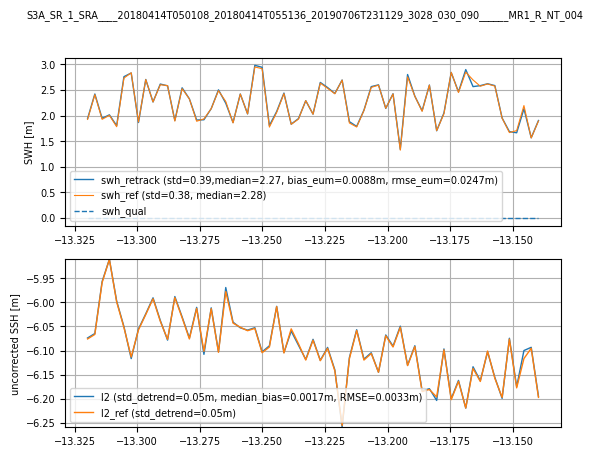

In [13]:
# add center-of-gravity (COG) correction to S3 L2 range data
cog_corr = 0.55590 if not is_s6 else 0.0

fig,rmse_swh,rmse_ssh = plot_l2_results_vs_ref(rp.output_l2,
                                               l2_ref=l2_ref,
                                               fig_title=l1b_file_path.stem,
                                               cog_corr=cog_corr,
                                               )

In [14]:
print(f'rmse_swh: {rmse_swh:.4f}, rmse_ssh: {rmse_ssh:.4f}')

rmse_swh: 0.0247, rmse_ssh: 0.0033


In [15]:
fig.savefig(dest_path / f'{"S6" if is_s6 else "S3"}_comparison_w_baseline.jpg')

## References

[1] SAMOSA Detailed Processing Model: Christine Gommenginger, Cristina Martin-Puig, Meric Srokosz, Marco Caparrini, Salvatore Dinardo, Bruno Lucas, Marco Restano, Américo, Ambrózio and Jérôme Benveniste, Detailed Processing Model of the Sentinel-3 SRAL SAR altimeter ocean waveform retracker, Version 2.5.2, 31 October 2017, Under ESA-ESRIN Contract No. 20698/07/I-LG (SAMOSA), Restricted access as defined in the Contract,  Jérôme Benveniste (Jerome.Benvensite@esa.int) pers. comm.

[2] EUMETSAT. Sentinel-6/Jason-CS ALT Level 2 Product Generation Specification (L2 ALT PGS), Version V4D; 2022.
https://www.eumetsat.int/media/48266.

[3] Dinardo, Salvatore. ‘Techniques and Applications for Satellite SAR Altimetry over Water, Land and Ice’.
Dissertation, Technische Universität, 2020. https://tuprints.ulb.tu-darmstadt.de/11343/.

[4] Schlembach, F.; Passaro, M.; Dettmering, D.; Bidlot, J.; Seitz, F. Interference-Sensitive Coastal SAR Altimetry
Retracking Strategy for Measuring Significant Wave Height. Remote Sensing of Environment 2022, 274, 112968. https://doi.org/10.1016/j.rse.2022.112968.

[5] Schlembach, F.; Ehlers, F.; Kleinherenbrink, M.; Passaro, M.; Dettmering, D.; Seitz, F.; Slobbe, C. Benefits of Fully Focused SAR Altimetry to Coastal Wave Height Estimates: A Case Study in the North Sea. Remote Sensing of Environment 2023, 289, 113517. https://doi.org/10.1016/j.rse.2023.113517.

